# Add Groundedness Check

- Author: [JeongGi Park](https://github.com/jeongkpa)
- Design: []()
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/07-LCEL-Interface.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/07-LCEL-Interface.ipynb)

## Overview


In this tutorial, we perform a Naive Retrieval-Augmented Generation (RAG) step and then add a relevance check (Groundedness Check) to evaluate how relevant the retrieved documents are for answering the question.



### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Basic PDF-based Retrieval Chain](#basic-pdf-based-retrieval-chain)
- [Defining State](#defining-state)
- [Degining Nodes](#degining-nodes)
- [Defining Edges](#defining-edges)
- [Running a graph](#running-a-graph)

### References
- [langgraph](https://langchain-ai.github.io/langgraph/)

---

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial -U

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain-openai",
        "langchain",
        "python-dotenv",
        "langchain-core",     
        "langchain-opentutorial"

    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Add Groundedness Check",
    },
)

Environment variables have been set successfully.


[Note] If you are using a `.env` file, proceed as follows.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Basic PDF-based Retrieval Chain

In this section, we create a simple retrieval chain based on PDF documents. 

We separate the Retriever and Chain so that we can customize each node within LangGraph.

![](./assets/03-langgraph-add-relevance-check.png)

In [5]:
from rag.base import RetrievalChain
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Annotated


class PDFRetrievalChain(RetrievalChain):
    def __init__(self, source_uri: Annotated[str, "Source URI"]):
        self.source_uri = source_uri
        self.k = 10

    def load_documents(self, source_uris: List[str]):
        docs = []
        for source_uri in source_uris:
            loader = PDFPlumberLoader(source_uri)
            docs.extend(loader.load())

        return docs

    def create_text_splitter(self):
        return RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

# Create a PDF-based retrieval chain
pdf_chain_builder = PDFRetrievalChain([
    "./data/A European Approach to Artificial intelligence - A Policy Perspective.pdf"  # Example PDF document
])

# The chain has two main components: retriever and chain
pdf = pdf_chain_builder.create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

print("PDF-based retrieval chain created.")


PDF-based retrieval chain created.


## Defining State

We define a `GraphState` that represents the shared state among nodes. 

It's typically a Python `TypedDict`. In this tutorial, the state includes a new key relevance to store the relevance check result.

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # The user's question
    context: Annotated[str, "Context"]    # The retrieved document context
    answer: Annotated[str, "Answer"]      # The final answer
    messages: Annotated[list, add_messages] # The conversation messages
    relevance: Annotated[str, "Relevance"] # The relevance check (e.g., "yes" or "no")

print("GraphState defined.")


GraphState defined.


## Degining Nodes

Nodes perform each step in the graph. Each node is implemented as a Python function that:

1. Takes the current `GraphState` as input.
2. Performs certain logic.
3. Returns an updated `GraphState`.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_opentutorial.evaluator import GroundednessChecker
from langchain_opentutorial.messages import messages_to_history

def format_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc.page_content}</content><source>{doc.metadata['source']}</source><page>{int(doc.metadata['page'])+1}</page></document>"
            for doc in docs
        ]
    )

# Document retrieval node
def retrieve_document(state: GraphState) -> GraphState:
    # Get the latest question from state
    latest_question = state["question"]
    
    # Retrieve relevant documents from the PDF retriever
    retrieved_docs = pdf_retriever.invoke(latest_question)
    
    # Format the retrieved documents for prompt usage
    retrieved_docs_formatted = format_docs(retrieved_docs)
    
    # Store the formatted documents into the state context
    return {
        **state,
        "context": retrieved_docs_formatted
    }

# Answer generation node
def llm_answer(state: GraphState) -> GraphState:
    # Get the latest question from state
    latest_question = state["question"]
    # Get the retrieved documents from state
    context = state["context"]

    # Generate answer using the chain
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # Update the state's answer and messages
    return {
        **state,
        "answer": response,
        "messages": state["messages"] + [("user", latest_question), ("assistant", response)],
    }

# Relevance check node
def relevance_check(state: GraphState) -> GraphState:
    # Create a relevance evaluator
    question_retrieval_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), 
        target="question-retrieval"
    ).create()

    # Perform relevance check (expected to return "yes" or "no")
    response = question_retrieval_relevant.invoke({
        "question": state["question"],
        "context": state["context"]
    })

    print("==== [RELEVANCE CHECK] ====\n", response.score)

    return {
        **state,
        "relevance": response.score
    }

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

print("Nodes defined.")


Nodes defined.


## Defining Edges

Edges define which node is executed next, based on the current `GraphState`. 

We can create conditional edges to handle different logic flows.

In [8]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create a graph with GraphState
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Add edges
workflow.add_edge("retrieve", "relevance_check")

# Add conditional edges from relevance_check to either llm_answer or retrieve again
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "retrieve"
    },
)

# End after generating answer
workflow.add_edge("llm_answer", END)

# Set the entry point
workflow.set_entry_point("retrieve")

# Initialize a memory checkpoint
memory = MemorySaver()

# Compile the graph
app = workflow.compile(checkpointer=memory)

print("Graph compiled.")


Graph compiled.


### Visualizing the Graph

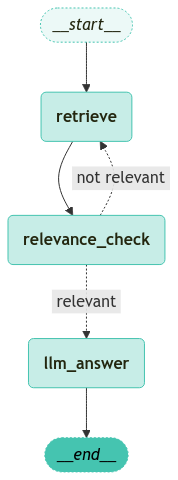

Graph visualization displayed.


In [10]:
### Visualizing the Graph

from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)
print("Graph visualization displayed.")


## Running a graph


The `config` parameter passes configuration information required when running the graph.
`recursion_limit`: Sets the maximum number of recursions when running the graph.
`inputs`: Passes input information required when running the graph.

In [11]:
### Execute the Graph

# Set a `recursion_limit` to prevent indefinite loops during relevance checks

from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import stream_graph, invoke_graph, random_uuid
from langgraph.errors import GraphRecursionError

# Create a configuration with recursion limit
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# Define the user question
inputs = GraphState(question="What are the three main principles of the European Union's approach to ensuring \"trustworthy AI,\" and why are they significant?")

# Execute the graph
try:
    invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])
    outputs = app.get_state(config)

    # Access the values dictionary within StateSnapshot
    output_values = outputs.values

    # Display the results
    print("\n--- OUTPUTS ---\n")
    print("Question:", output_values["question"])
    print("Answer:\n", output_values["answer"])
    print("Relevance:", output_values["relevance"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")
except Exception as e:
    print(f"Unexpected Error: {e}")


==== [RELEVANCE CHECK] ====
 yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
What are the three main principles of the European Union's approach to ensuring "trustworthy AI," and why are they significant?
context:
<document><content>A EUROPEAN APPROACH TO ARTIFICIAL INTELLIGENCE - A POLICY PERSPECTIVE
laws and regulation. Some negative examples have been given order to achieve ‘trustworthy AI’, three components are necessary:</content><source>./data/A European Approach to Artificial intelligence - A Policy Perspective.pdf</source><page>5</page></document>
<document><content>(Teich & Tirias Research, 2018). Such examples are fuelling a va- trustworthy5. These policies culminated in the White Paper on AI
riety of concerns about accountability, fairness, bias, autonomy, – A European Approach to Excellence and Trust (European Com-</content><source>./data/A European Approach to Artificial intelligence - A Policy Perspective.pdf</source><page>5</pa

However, if the `relevance_check` of the search result fails, the same query is repeatedly entered into the retrieve node.

If the same query is repeatedly entered into the retrieve node, it will lead to the same search result, which will eventually lead to a recursion.

To prevent possible recursion states, we set the maximum number of recursions (`recursion_limit`) and handle `GraphRecursionError` for error handling.